# Using EcoFOCIpy to process raw field data

## DY2103 (Spring Mooring Cruise - Oscar Dyson)

## CTD / BTL Data

This is a streamlined version of the EcoFOCIpy_sbe_ctd_btlfile_DY2103.ipynb and can be used to create simple python scripts.  It is signifcantly less commented and doesn't show step by step examples

In [1]:
import yaml
import glob

import EcoFOCIpy.io.sbe_ctd_parser as sbe_ctd_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

In [2]:
sample_data_dir = '/Users/bell/ecoraid/2021/CTDcasts/dy2103/' #root path to cruise directory
EcoFOCIpy_dir = '/Users/bell/Programs/EcoFOCIpy/'

In [3]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2103' #no hyphens
cruise_meta_file = sample_data_dir+'logs/DY2103.yaml'
inst_meta_file = sample_data_dir+'logs/FOCI_standard_CTDplusrinko.yaml' #<- copy to each deployment for simplicity?
group_meta_file = EcoFOCIpy_dir+'staticdata/institutional_meta_example.yaml'
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe_btl()
filename_list = sorted(glob.glob(datafile + '*.btl'))

cruise_data = cruise.manual_parse(filename_list)

## Add Deployment meta information

In [4]:
#just a dictionary of dictionaries - simple
with open(cruise_meta_file) as file:
    cruise_config = yaml.full_load(file)

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [5]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

## Add institutional meta-information


In [6]:
with open(group_meta_file) as file:
    group_config = yaml.full_load(file)

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [7]:
#loop over all casts and perform tasks shown above

for cast in cruise_data.keys():
    try:
        cruise_data[cast] = cruise_data[cast].rename(columns={
                            't090c':'temperature_ch1',
                            't190c':'temperature_ch2',
                            'sal00':'salinity_ch1',
                            'sal11':'salinity_ch2',
                            'sbox0mm/kg':'oxy_conc_ch1',
                            'sbeox0ml/l':'oxy_concM_ch1',
                            'sbox1mm/kg':'oxy_conc_ch2',
                            'sbeox1ml/l':'oxy_concM_ch2',
                            'sbeox0ps':'oxy_percentsat_ch1',
                            'sbeox1ps':'oxy_percentsat_ch2',
                            'sigma-t00':'sigma_t_ch1',
                            'sigma-t11':'sigma_t_ch2',
                            'cstarat0':'Attenuation',
                            'cstartr0':'Transmittance',
                            'fleco-afl':'chlor_fluorescence',
                            'turbwetntu0':'turbidity',
                            'prdm':'pressure',
                            'empty':'empty', #this will be ignored
                            'flag':'flag'})

        cruise_data_nc = ncCFsave.EcoFOCI_CFnc(df=cruise_data[cast], 
                                    instrument_yaml=inst_config, 
                                    operation_yaml=cruise_config,
                                    operation_type='ctd')

        cruise_data_nc.expand_dimensions(dim_names=['latitude','longitude','time'],geophys_sort=False)

        cruise_data_nc.variable_meta_data(variable_keys=list(cruise_data[cast].columns.values),drop_missing=True)
        #adding dimension meta needs to come after updating the dimension values... BUG?
        cruise_data_nc.dimension_meta_data(variable_keys=['time','latitude','longitude'])
        cruise_data_nc.temporal_geospatioal_meta_data_ctd(positiveE=False,conscastno=cast.split('.')[0])

        #add global attributes
        cruise_data_nc.deployment_meta_add(conscastno=cast.split('.')[0].upper())

        #add instituitonal global attributes
        cruise_data_nc.institution_meta_add(group_config)

        #add creation date/time - provenance data
        cruise_data_nc.provinance_meta_add()

        #provide intial qc status field
        cruise_data_nc.qc_status(qc_status='unqcd') #<- options are unknown, excellent, probably good, mixed, unqcd

        cast = cast.lower().split('d')[-1].split('.')[0]
        cruise_data_nc.xarray2netcdf_save(xdf = cruise_data_nc.get_xdf(),
                                   filename=cruise_name+'c'+cast.zfill(3)+'_btl.nc',format="NETCDF3_CLASSIC")
    except:
        print(f'Skipping {cast}')

Skipping ctd017test.btl
Skipping ctd021.btl
Skipping ctd079.btl


## Bottle Report File
- this is just a synthesized bottle file that gets used for discrete sample matching with the mean values from all bottles in one file

In [14]:
for cast in cruise_data.keys():
    try:
        cruise_data[cast] = cruise_data[cast].rename(columns={
                            't090c':'temperature_ch1',
                            't190c':'temperature_ch2',
                            'sal00':'salinity_ch1',
                            'sal11':'salinity_ch2',
                            'sbox0mm/kg':'oxy_conc_ch1',
                            'sbeox0ml/l':'oxy_concM_ch1',
                            'sbox1mm/kg':'oxy_conc_ch2',
                            'sbeox1ml/l':'oxy_concM_ch2',
                            'sbeox0ps':'oxy_percentsat_ch1',
                            'sbeox1ps':'oxy_percentsat_ch2',
                            'sigma-t00':'sigma_t_ch1',
                            'sigma-t11':'sigma_t_ch2',
                            'cstarat0':'Attenuation',
                            'cstartr0':'Transmittance',
                            'fleco-afl':'chlor_fluorescence',
                            'turbwetntu0':'turbidity',
                            'prdm':'pressure',
                            'empty':'empty', #this will be ignored
                            'flag':'flag'})
        
        df=cruise_data[cast]
        df['cast'] = cast.lower().split('.')[0]
        if cast.lower().split('.')[0] == 'ctd001':
            df.to_csv(f'{cruise_name}.report_btl')
        else:
            df.to_csv(f'{cruise_name}.report_btl',mode='a', header=False)
    except:
        print(f'some issue in {cast}')

mean: -0.002319119878603721 median: -0.0011999999999972033 std: 0.04767285169664037


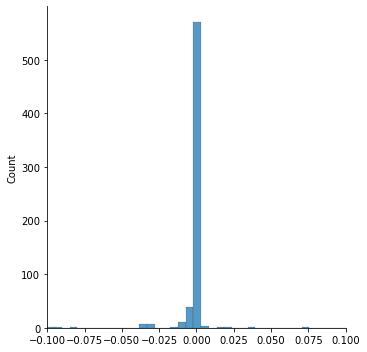

In [40]:
#read in file and generate a distribution of salinity differences
import pandas as pd
import seaborn as sns

df = pd.read_csv(f'{cruise_name}.report_btl')
ax = sns.displot(df['salinity_ch1']-df['salinity_ch2'],kind='hist',bins=250)
ax.set(xlim=(-.1, .1))
print('mean:',(df['salinity_ch1']-df['salinity_ch2']).mean(), 
      'median:',(df['salinity_ch1']-df['salinity_ch2']).median(), 
      'std:', (df['salinity_ch1']-df['salinity_ch2']).std())

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

KeyError: 'CruiseID'